# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tf_keras.models import Sequential
from tf_keras.layers import SimpleRNN, Dense, Dropout
from tf_keras.regularizers import l2
from tf_keras.metrics import Precision, AUC
from tf_keras.optimizers import Adam

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Helper Functions

## Visualise Loss

In [2]:
def visualise_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.show()
    return None

## Visualise Confusion Matrix

In [3]:
def get_conf_mat(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)  # For binary classification, probabilities will be returned

    # Step 2: Convert probabilities to class labels
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # For binary classification
    try:
        y_pred_classes = [pred[0][0] for pred in y_pred_classes]
    except:
        print("ok")
    # Step 3: Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    return conf_matrix

def visualise_mat(mat):
    sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return None

## Get Scores

In [4]:
def get_score(mat, hi = None):
    cur_mat = mat
    acc = (cur_mat[0][0] + cur_mat[1][1])/sum(sum(cur_mat))
    pre = (cur_mat[1][1])/(cur_mat[1][1] + cur_mat[0][1])
    rec = (cur_mat[1][1])/(cur_mat[1][1] + cur_mat[1][0])
    f1 = (2*pre*rec)/(pre + rec)
    if (hi):
        print(f"Accuracy: {round(acc, 2)}")
        print(f"Precision: {round(pre, 2)}")
        print(f"Recall: {round(rec, 2)}")
        print(f"F1 Score: {round(f1, 2)}")
    return acc, pre, rec, f1

## Pad Function for BERT

In [5]:
# Assuming x_train is your data array with varying sequence lengths
desired_shape = (15, 768)
# Define a function to pad or truncate each sequence to the desired shape
def pad(seq, target_shape):
    # Pad with zeros if the sequence is shorter than the target length
    if seq.shape[1] <= target_shape[0]:
        padding_needed = target_shape[0] - seq.shape[1]
        # Pad at the end of the sequence
        padding = np.zeros((padding_needed, target_shape[1]), dtype=seq.dtype)
        return np.vstack([seq[0], padding])
    
    # Return as-is if the sequence already matches the target length
    return seq

## Cross Validiation for BERT

In [6]:
from sklearn.utils.class_weight import compute_class_weight

def bert_cross(split, X, y, create_model, batch=32, lr=0.001, ep = 10, cw = False):
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)

    fold_matrices = []
    scores = np.array([0.0, 0.0, 0.0, 0.0])
    X_padded = np.array([pad(seq, desired_shape) for seq in X])

    for train_idx, val_idx in kfold.split(X_padded, y):
        # Split data
        X_train, X_val = X_padded[train_idx], X_padded[val_idx]
        y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]
        
        # Create a new instance of the model
        model = create_model(lr)
        
        # Train the model
        if cw:
            class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
            )
            class_weights = dict(enumerate(class_weights))
            model.fit(
                X_train,
                y_train,
                epochs=ep,
                batch_size=batch,
                verbose=2,
                class_weight=class_weights  # Pass class weights here
            )
        else:
            model.fit(
                X_train,
                y_train,
                epochs=ep,
                batch_size=batch,
                verbose=2
            )
        # Make predictions
        y_val_pred = (model.predict(X_val) > 0.5).astype(int)

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        fold_matrices.append(conf_matrix)

        # Update scores
        scores += np.array(get_score(conf_matrix))
    
    # Aggregate confusion matrices
    final_matrix = np.array([[0, 0], [0, 0]])
    for mat in fold_matrices:
        final_matrix += np.array(mat)
    
    # Visualize and print results
    visualise_mat(final_matrix)
    print(f"Accuracy: {round(scores[0]/split, 2)}")
    print(f"Precision: {round(scores[1]/split, 2)}")
    print(f"Recall: {round(scores[2]/split, 2)}")
    print(f"F1 Score: {round(scores[3]/split, 2)}")


    

# RNN + TFIDF

In [3]:
# Code for this dataset is in another notebook
sent_df = pd.read_csv("../Datasets/sentiment.csv")

In [4]:
df = sent_df.dropna(subset=["comment", "label"])

In [5]:
X = df["comment"]
X

0                                                    nc nh
1                          significant spending tax dollar
2                                  bother he sign weakness
3        conservatism ideology reaction liberalism deve...
4               maybe control certainly evidence collusion
                               ...                        
82754                          woman lead man anyway bible
82755                                          thank union
82756                                                    o
82757                        slavs get country call kosovo
82758                            value capitalism imprison
Name: comment, Length: 81750, dtype: object

In [10]:
y = df["label"]
y

0        0
1        0
2        0
3        0
4        0
        ..
82754    1
82755    1
82756    1
82757    1
82758    1
Name: label, Length: 81750, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2, random_state=42)

In [16]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(list(X_train))
X_test = vectorizer.transform(list(X_test))

In [17]:
X_train.shape

(65400, 13804)

In [50]:
X_train_reshaped = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

In [51]:
# Build the RNN model

def create_tfidf_model():
    model = Sequential([
        SimpleRNN(16, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
        ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Precision(), AUC()])
    return model

In [52]:
tfidf_model = create_tfidf_model()

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
tfidf_history = tfidf_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1635/1635 [==============================] - 7s 4ms/step - loss: 0.6240 - precision_3: 0.6507 - auc_3: 0.6779 - val_loss: 0.5990 - val_precision_3: 0.6972 - val_auc_3: 0.7179
Epoch 2/10
1635/1635 [==============================] - 4s 3ms/step - loss: 0.5611 - precision_3: 0.7377 - auc_3: 0.7718 - val_loss: 0.6028 - val_precision_3: 0.7056 - val_auc_3: 0.7141
Epoch 3/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5342 - precision_3: 0.7598 - auc_3: 0.7994 - val_loss: 0.6138 - val_precision_3: 0.7150 - val_auc_3: 0.7084
Epoch 4/10
1635/1635 [==============================] - 3s 2ms/step - loss: 0.5183 - precision_3: 0.7712 - auc_3: 0.8136 - val_loss: 0.6251 - val_precision_3: 0.7089 - val_auc_3: 0.7027
Epoch 5/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5070 - precision_3: 0.7767 - auc_3: 0.8226 - val_loss: 0.6359 - val_precision_3: 0.7078 - val_auc_3: 0.6976
Epoch 6/10
1635/1635 [==============================] - 3s 2ms/step - 

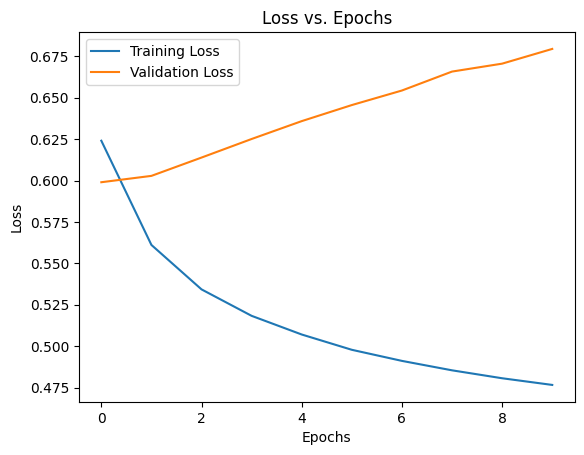

In [53]:
visualise_loss(tfidf_history)

In [54]:
tfidf_model.evaluate(X_test_reshaped, y_test)

511/511 [==============================] - 1s 1ms/step - loss: 0.6788 - precision_3: 0.7015 - auc_3: 0.6857


[0.6787594556808472, 0.7015019059181213, 0.6857301592826843]

In [55]:
tfidf_conf_matrix = get_conf_mat(tfidf_model, X_test_reshaped, y_test)
tfidf_conf_matrix

511/511 [==============================] - 1s 1ms/step


array([[2917, 3339],
       [2247, 7847]], dtype=int64)

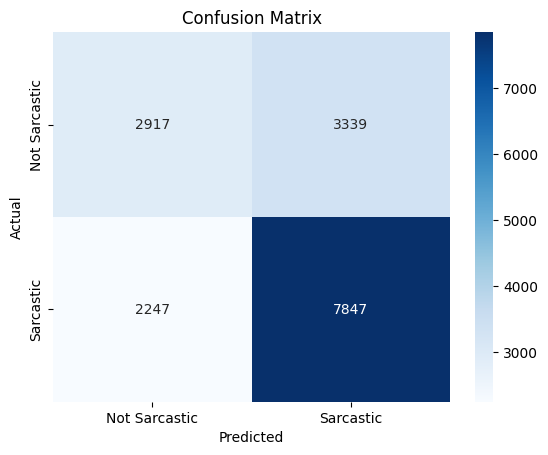

In [56]:
visualise_mat(tfidf_conf_matrix)

In [57]:
get_score(tfidf_conf_matrix)

(0.658348623853211, 0.7015018773466833, 0.7773925104022191, 0.7375)

Epoch 1/10
2044/2044 - 7s - loss: 0.6180 - precision_8: 0.6600 - auc_8: 0.6889 - 7s/epoch - 4ms/step
Epoch 2/10
2044/2044 - 13s - loss: 0.5611 - precision_8: 0.7368 - auc_8: 0.7704 - 13s/epoch - 7ms/step
Epoch 3/10
2044/2044 - 8s - loss: 0.5398 - precision_8: 0.7550 - auc_8: 0.7922 - 8s/epoch - 4ms/step
Epoch 4/10
2044/2044 - 8s - loss: 0.5261 - precision_8: 0.7636 - auc_8: 0.8047 - 8s/epoch - 4ms/step
Epoch 5/10
2044/2044 - 9s - loss: 0.5166 - precision_8: 0.7690 - auc_8: 0.8122 - 9s/epoch - 4ms/step
Epoch 6/10
2044/2044 - 7s - loss: 0.5095 - precision_8: 0.7722 - auc_8: 0.8174 - 7s/epoch - 3ms/step
Epoch 7/10
2044/2044 - 7s - loss: 0.5033 - precision_8: 0.7764 - auc_8: 0.8216 - 7s/epoch - 3ms/step
Epoch 8/10
2044/2044 - 6s - loss: 0.4981 - precision_8: 0.7771 - auc_8: 0.8254 - 6s/epoch - 3ms/step
Epoch 9/10
2044/2044 - 7s - loss: 0.4947 - precision_8: 0.7787 - auc_8: 0.8276 - 7s/epoch - 3ms/step
Epoch 10/10
2044/2044 - 8s - loss: 0.4912 - precision_8: 0.7814 - auc_8: 0.8299 - 8s/epoc

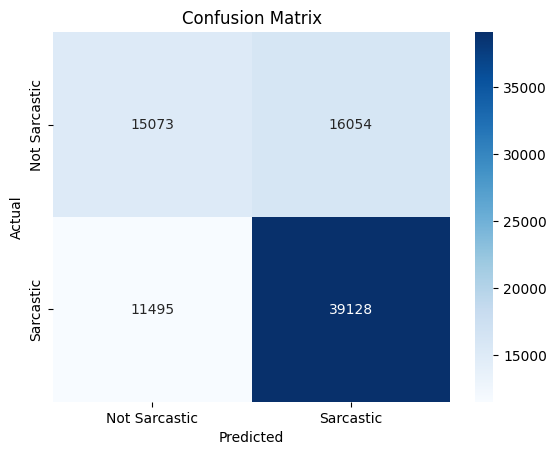

In [67]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_matrices = []
scores = np.array([0.0, 0.0, 0.0, 0.0])

for train_idx, val_idx in kfold.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    # Apply TFIDF
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(list(X_train))
    X_val = vectorizer.transform(list(X_val))
    # Split y
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Reshape X_train and X_val
    X_train_reshaped = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_reshaped = X_val.toarray().reshape(X_val.shape[0], 1, X_val.shape[1])
        
    # Create a new instance of the model
    model = create_tfidf_model()
    
    # Train the model
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=2)

    # y_val_pred = (model.predict(X_val_reshaped) > 0.5).astype(int)
    # conf_matrix = confusion_matrix(y_val, y_val_pred)
    conf_matrix = get_conf_mat(model, X_val_reshaped, y_val)
    fold_matrices.append(conf_matrix)
    scores += np.array(get_score(conf_matrix))

final_matrix = np.array([[0, 0], [0, 0]])
for mat in fold_matrices:
    final_matrix += np.array(mat)

print(f"Accuracy: {round(scores[0]/5, 2)}")
print(f"Precision: {round(scores[1]/5, 2)}")
print(f"Recall: {round(scores[2]/5, 2)}")
print(f"F1 Score: {round(scores[3]/5, 2)}")

visualise_mat(final_matrix)


# RNN + Bert

## Getting Bert Embedding

In [6]:
# Code for Bert Embedding is in another notebook
train_df = pd.read_pickle('../Datasets/bert_embeddings_no_pooling_train.pkl')

In [8]:
train_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,bert_comment,seq_len
0,0,nc and nh.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"yeah, i get that argument. at this point, i'd ...","[[[-0.26591256, -0.29882812, -0.040224716, -0....",3
10,0,i think a significant amount would be against ...,ThisIsNotKimJongUn,politics,92,92,0,2016-09,2016-09-20 17:53:52,i bet if that money was poured into college de...,"[[[0.075774364, 0.03500098, -0.04244519, -0.05...",15
17,0,because it's what really bothers him... and it...,kozmo1313,politics,15,-1,-1,2016-12,2016-12-26 20:10:45,he actually acts like a moody emo girl on twit...,"[[[0.03299582, 0.04939469, -0.08288911, -0.163...",12
22,0,conservatism as an ideology is for sure a reac...,MayorMcCheese59,politics,1,-1,-1,2016-12,2016-12-24 00:04:06,"i still doubt that ""all conservatives stand fo...","[[[-0.1579521, -0.00796949, -0.33657235, -0.09...",29
23,0,"maybe not control, but certainly that is evide...",SunTzu-,politics,1,-1,-1,2016-10,2016-10-13 20:48:14,today russian media tweeted out that wikileaks...,"[[[-0.093258426, -0.08815382, -0.058376268, -0...",10
...,...,...,...,...,...,...,...,...,...,...,...,...
1010808,1,women shouldn't lead men anyway... it's in the...,musashiXXX,news,1,1,0,2009-09,2009-09-01 14:14:27,read the comment section. the glenn beck fluff...,"[[[0.13645245, -0.047203332, -0.19071074, -0.0...",9
1010811,1,thank you unions.,boot20,politics,2,2,0,2009-05,2009-05-28 05:18:11,no wonder california is broke - the $350k nurs...,"[[[0.00220339, 0.035776787, 0.047628716, -0.05...",3
1010820,1,:o,DiarrheaMonkey,politics,1,1,0,2009-04,2009-04-15 03:02:01,us combat troops may stay in northern iraq aft...,"[[[-0.1890865, -0.13287237, 0.17621507, -0.315...",1
1010824,1,the slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,i've always been unsettled by that. i hear a l...,"[[[-0.16559607, -0.102044925, -0.23074053, -0....",11


### Getting X

In [9]:
X = train_df["bert_comment"]
X

0          [[[-0.26591256, -0.29882812, -0.040224716, -0....
10         [[[0.075774364, 0.03500098, -0.04244519, -0.05...
17         [[[0.03299582, 0.04939469, -0.08288911, -0.163...
22         [[[-0.1579521, -0.00796949, -0.33657235, -0.09...
23         [[[-0.093258426, -0.08815382, -0.058376268, -0...
                                 ...                        
1010808    [[[0.13645245, -0.047203332, -0.19071074, -0.0...
1010811    [[[0.00220339, 0.035776787, 0.047628716, -0.05...
1010820    [[[-0.1890865, -0.13287237, 0.17621507, -0.315...
1010824    [[[-0.16559607, -0.102044925, -0.23074053, -0....
1010825    [[[-0.17583698, -0.0315043, -0.066449955, 0.06...
Name: bert_comment, Length: 82764, dtype: object

### Getting y

In [10]:
y = train_df["label"]
y

0          0
10         0
17         0
22         0
23         0
          ..
1010808    1
1010811    1
1010820    1
1010824    1
1010825    1
Name: label, Length: 82764, dtype: int64

## Training

### Simple Model to Compare with TFIDF

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train_padded = np.array([pad(seq, desired_shape) for seq in X_train])
X_test_padded = np.array([pad(seq, desired_shape) for seq in X_test])

In [13]:
# Create Bert 1 model
def create_bert1_model(lr):
    model = Sequential([
        SimpleRNN(16, input_shape=(15, 768)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=[Precision(), AUC()])
    return model

In [142]:
# Compile the model
bert1_model = create_bert1_model(0.001)

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1656/1656 [==============================] - 6s 3ms/step - loss: 0.6299 - precision_43: 0.6737 - auc_43: 0.6591 - val_loss: 0.5870 - val_precision_43: 0.7504 - val_auc_43: 0.7372
Epoch 2/10
1656/1656 [==============================] - 5s 3ms/step - loss: 0.5874 - precision_43: 0.7208 - auc_43: 0.7294 - val_loss: 0.5799 - val_precision_43: 0.7182 - val_auc_43: 0.7370
Epoch 3/10
1656/1656 [==============================] - 4s 2ms/step - loss: 0.5757 - precision_43: 0.7312 - auc_43: 0.7443 - val_loss: 0.5625 - val_precision_43: 0.7517 - val_auc_43: 0.7594
Epoch 4/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.5684 - precision_43: 0.7381 - auc_43: 0.7533 - val_loss: 0.5765 - val_precision_43: 0.7886 - val_auc_43: 0.7526
Epoch 5/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.5645 - precision_43: 0.7421 - auc_43: 0.7578 - val_loss: 0.5633 - val_precision_43: 0.7759 - val_auc_43: 0.7627
Epoch 6/10
1656/1656 [============================

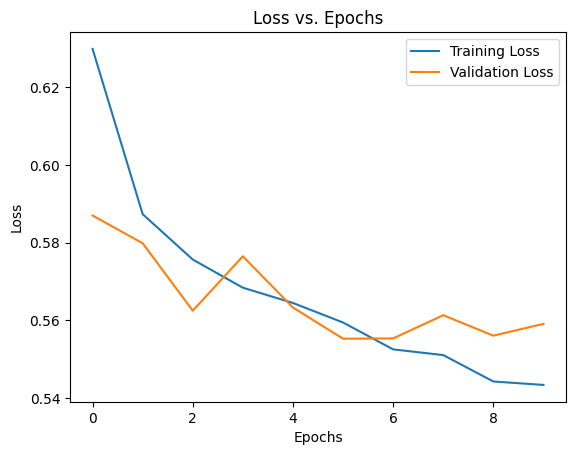

In [143]:
visualise_loss(bert1_history)

In [144]:
bert1_model.evaluate(X_test_padded, y_test)

518/518 [==============================] - 1s 2ms/step - loss: 0.5633 - precision_43: 0.7678 - auc_43: 0.7660


[0.5632616877555847, 0.7678031325340271, 0.7659712433815002]

In [145]:
bert1_conf_matrix = get_conf_mat(bert1_model, X_test_padded, y_test)
bert1_conf_matrix

518/518 [==============================] - 1s 2ms/step
ok


array([[4132, 2302],
       [2507, 7612]], dtype=int64)

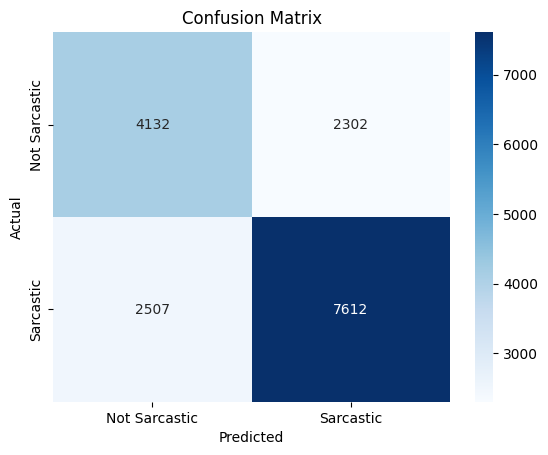

In [146]:
visualise_mat(bert1_conf_matrix)

In [147]:
score = get_score(bert1_conf_matrix, "as")

Accuracy: 0.71
Precision: 0.77
Recall: 0.75
F1 Score: 0.76


Epoch 1/10
2070/2070 - 6s - loss: 0.6098 - precision_44: 0.7011 - auc_44: 0.6974 - 6s/epoch - 3ms/step
Epoch 2/10
2070/2070 - 5s - loss: 0.5804 - precision_44: 0.7258 - auc_44: 0.7379 - 5s/epoch - 2ms/step
Epoch 3/10
2070/2070 - 5s - loss: 0.5717 - precision_44: 0.7329 - auc_44: 0.7485 - 5s/epoch - 2ms/step
Epoch 4/10
2070/2070 - 5s - loss: 0.5670 - precision_44: 0.7369 - auc_44: 0.7542 - 5s/epoch - 2ms/step
Epoch 5/10
2070/2070 - 6s - loss: 0.5606 - precision_44: 0.7438 - auc_44: 0.7616 - 6s/epoch - 3ms/step
Epoch 6/10
2070/2070 - 6s - loss: 0.5573 - precision_44: 0.7467 - auc_44: 0.7656 - 6s/epoch - 3ms/step
Epoch 7/10
2070/2070 - 5s - loss: 0.5529 - precision_44: 0.7487 - auc_44: 0.7704 - 5s/epoch - 3ms/step
Epoch 8/10
2070/2070 - 5s - loss: 0.5511 - precision_44: 0.7505 - auc_44: 0.7725 - 5s/epoch - 3ms/step
Epoch 9/10
2070/2070 - 5s - loss: 0.5472 - precision_44: 0.7541 - auc_44: 0.7766 - 5s/epoch - 2ms/step
Epoch 10/10
2070/2070 - 5s - loss: 0.5421 - precision_44: 0.7564 - auc_44

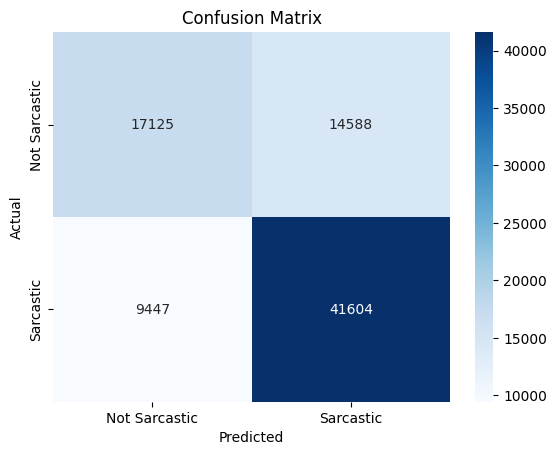

Accuracy: 0.71
Precision: 0.74
Recall: 0.81
F1 Score: 0.78


In [151]:
bert_cross(5, X, y, create_bert1_model, 32, 0.001)

### Change Learning Rate

In [118]:
bert1_model = create_bert1_model(0.0001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_lr4_history = bert1_model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1656/1656 [==============================] - 22s 13ms/step - loss: 0.6697 - precision_35: 0.6359 - auc_35: 0.5690 - val_loss: 0.6283 - val_precision_35: 0.6800 - val_auc_35: 0.6579
Epoch 2/20
1656/1656 [==============================] - 44s 26ms/step - loss: 0.6194 - precision_35: 0.6896 - auc_35: 0.6790 - val_loss: 0.5919 - val_precision_35: 0.7165 - val_auc_35: 0.7220
Epoch 3/20
1656/1656 [==============================] - 38s 23ms/step - loss: 0.5959 - precision_35: 0.7150 - auc_35: 0.7184 - val_loss: 0.5795 - val_precision_35: 0.7232 - val_auc_35: 0.7397
Epoch 4/20
1656/1656 [==============================] - 12s 7ms/step - loss: 0.5847 - precision_35: 0.7255 - auc_35: 0.7338 - val_loss: 0.5736 - val_precision_35: 0.7370 - val_auc_35: 0.7464
Epoch 5/20
1656/1656 [==============================] - 11s 7ms/step - loss: 0.5778 - precision_35: 0.7306 - auc_35: 0.7429 - val_loss: 0.5696 - val_precision_35: 0.7337 - val_auc_35: 0.7511
Epoch 6/20
1656/1656 [====================

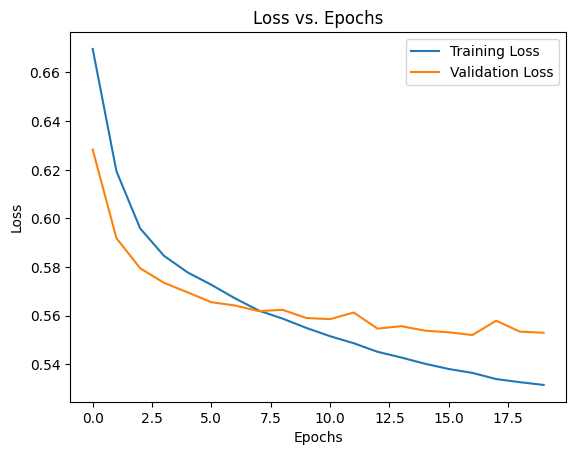

In [119]:
visualise_loss(bert1_lr4_history)

### Change Batch Size


In [120]:
# Learning rate change back to 0.001
bert1_model = create_bert1_model(0.001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
828/828 [==============================] - 10s 10ms/step - loss: 0.6324 - precision_36: 0.6603 - auc_36: 0.6491 - val_loss: 0.5827 - val_precision_36: 0.7248 - val_auc_36: 0.7350
Epoch 2/20
828/828 [==============================] - 7s 8ms/step - loss: 0.5892 - precision_36: 0.7217 - auc_36: 0.7262 - val_loss: 0.5706 - val_precision_36: 0.7615 - val_auc_36: 0.7523
Epoch 3/20
828/828 [==============================] - 8s 9ms/step - loss: 0.5759 - precision_36: 0.7329 - auc_36: 0.7441 - val_loss: 0.5647 - val_precision_36: 0.7797 - val_auc_36: 0.7607
Epoch 4/20
828/828 [==============================] - 7s 9ms/step - loss: 0.5670 - precision_36: 0.7384 - auc_36: 0.7551 - val_loss: 0.5562 - val_precision_36: 0.7526 - val_auc_36: 0.7663
Epoch 5/20
828/828 [==============================] - 9s 11ms/step - loss: 0.5590 - precision_36: 0.7457 - auc_36: 0.7646 - val_loss: 0.5592 - val_precision_36: 0.7565 - val_auc_36: 0.7656
Epoch 6/20
828/828 [==============================] - 8s 

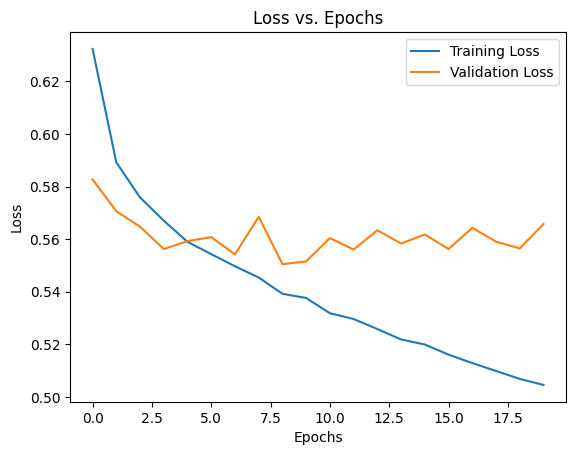

In [121]:
visualise_loss(bert1_bs64_history)

### Change Both Batch Size and Learning Rate

In [124]:
bert1_model = create_bert1_model(0.0001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_lr4_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
828/828 [==============================] - 49s 57ms/step - loss: 0.6528 - precision_38: 0.6595 - auc_38: 0.6191 - val_loss: 0.6029 - val_precision_38: 0.7075 - val_auc_38: 0.7054
Epoch 2/20
828/828 [==============================] - 8s 10ms/step - loss: 0.6093 - precision_38: 0.6997 - auc_38: 0.6980 - val_loss: 0.5876 - val_precision_38: 0.7231 - val_auc_38: 0.7272
Epoch 3/20
828/828 [==============================] - 8s 9ms/step - loss: 0.5966 - precision_38: 0.7122 - auc_38: 0.7175 - val_loss: 0.5784 - val_precision_38: 0.7232 - val_auc_38: 0.7395
Epoch 4/20
828/828 [==============================] - 7s 9ms/step - loss: 0.5899 - precision_38: 0.7180 - auc_38: 0.7270 - val_loss: 0.5754 - val_precision_38: 0.7222 - val_auc_38: 0.7426
Epoch 5/20
828/828 [==============================] - 9s 10ms/step - loss: 0.5818 - precision_38: 0.7237 - auc_38: 0.7370 - val_loss: 0.5708 - val_precision_38: 0.7204 - val_auc_38: 0.7501
Epoch 6/20
828/828 [==============================] - 10

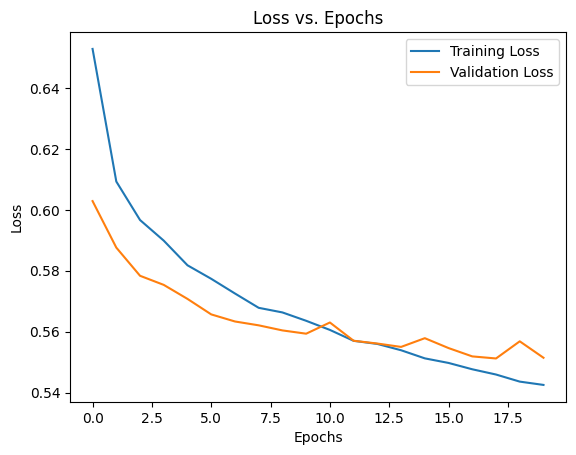

In [125]:
visualise_loss(bert1_lr4_bs64_history)

In [130]:
bert1_model = create_bert1_model(0.00001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_lr5_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
828/828 [==============================] - 4s 4ms/step - loss: 0.7050 - precision_41: 0.6207 - auc_41: 0.5149 - val_loss: 0.6722 - val_precision_41: 0.6318 - val_auc_41: 0.5395
Epoch 2/100
828/828 [==============================] - 3s 3ms/step - loss: 0.6883 - precision_41: 0.6285 - auc_41: 0.5390 - val_loss: 0.6603 - val_precision_41: 0.6352 - val_auc_41: 0.5706
Epoch 3/100
828/828 [==============================] - 3s 3ms/step - loss: 0.6772 - precision_41: 0.6344 - auc_41: 0.5615 - val_loss: 0.6509 - val_precision_41: 0.6393 - val_auc_41: 0.5987
Epoch 4/100
828/828 [==============================] - 3s 3ms/step - loss: 0.6675 - precision_41: 0.6412 - auc_41: 0.5829 - val_loss: 0.6426 - val_precision_41: 0.6536 - val_auc_41: 0.6239
Epoch 5/100
828/828 [==============================] - 3s 3ms/step - loss: 0.6595 - precision_41: 0.6506 - auc_41: 0.6020 - val_loss: 0.6352 - val_precision_41: 0.6625 - val_auc_41: 0.6418
Epoch 6/100
828/828 [==============================] - 

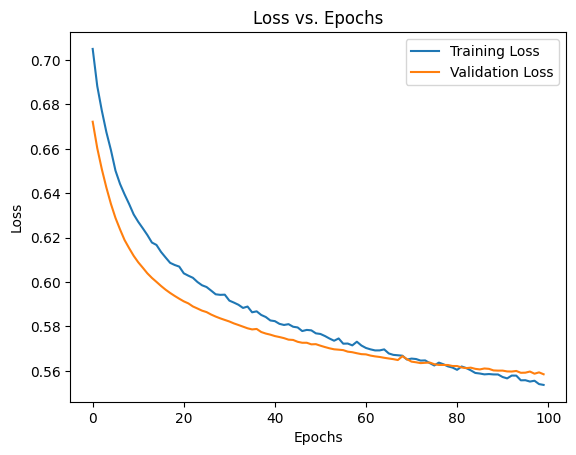

In [131]:
visualise_loss(bert1_lr5_bs64_history)


Epoch 1/10

1035/1035 - 4s - loss: 0.6540 - precision: 0.6490 - auc: 0.6008 - 4s/epoch - 4ms/step
Epoch 2/10
1035/1035 - 3s - loss: 0.6067 - precision: 0.7007 - auc: 0.7009 - 3s/epoch - 3ms/step
Epoch 3/10
1035/1035 - 3s - loss: 0.5897 - precision: 0.7184 - auc: 0.7269 - 3s/epoch - 2ms/step
Epoch 4/10
1035/1035 - 2s - loss: 0.5802 - precision: 0.7255 - auc: 0.7390 - 2s/epoch - 2ms/step
Epoch 5/10
1035/1035 - 2s - loss: 0.5735 - precision: 0.7325 - auc: 0.7476 - 2s/epoch - 2ms/step
Epoch 6/10
1035/1035 - 3s - loss: 0.5678 - precision: 0.7379 - auc: 0.7542 - 3s/epoch - 3ms/step
Epoch 7/10
1035/1035 - 3s - loss: 0.5644 - precision: 0.7416 - auc: 0.7581 - 3s/epoch - 3ms/step
Epoch 8/10
1035/1035 - 3s - loss: 0.5610 - precision: 0.7448 - auc: 0.7621 - 3s/epoch - 3ms/step
Epoch 9/10
1035/1035 - 3s - loss: 0.5584 - precision: 0.7451 - auc: 0.7649 - 3s/epoch - 3ms/step
Epoch 10/10
1035/1035 - 3s - loss: 0.5562 - precision: 0.7486 - auc: 0.7676 - 3s/epoch - 2ms/step
518/518 [==================

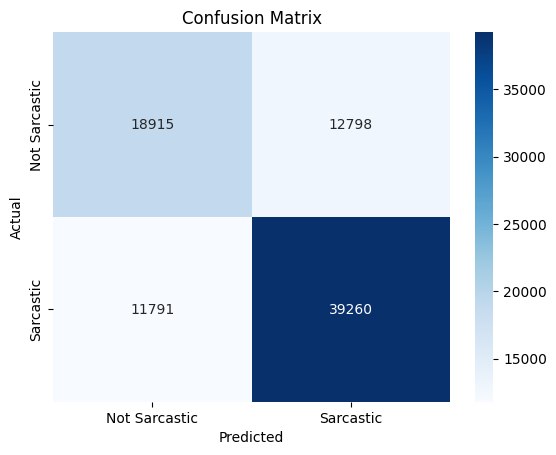

Accuracy: 0.7
Precision: 0.76
Recall: 0.77
F1 Score: 0.76


In [14]:
bert_cross(5, X, y, create_bert1_model, 64, 0.0001)

Epoch 1/10
1035/1035 - 4s - loss: 0.6623 - precision_5: 0.7094 - auc_5: 0.6411 - 4s/epoch - 4ms/step
Epoch 2/10
1035/1035 - 3s - loss: 0.6222 - precision_5: 0.7590 - auc_5: 0.7129 - 3s/epoch - 3ms/step
Epoch 3/10
1035/1035 - 3s - loss: 0.6084 - precision_5: 0.7717 - auc_5: 0.7312 - 3s/epoch - 3ms/step
Epoch 4/10
1035/1035 - 3s - loss: 0.6003 - precision_5: 0.7794 - auc_5: 0.7411 - 3s/epoch - 3ms/step
Epoch 5/10
1035/1035 - 3s - loss: 0.5940 - precision_5: 0.7851 - auc_5: 0.7485 - 3s/epoch - 3ms/step
Epoch 6/10
1035/1035 - 3s - loss: 0.5893 - precision_5: 0.7889 - auc_5: 0.7538 - 3s/epoch - 3ms/step
Epoch 7/10
1035/1035 - 3s - loss: 0.5848 - precision_5: 0.7925 - auc_5: 0.7586 - 3s/epoch - 3ms/step
Epoch 8/10
1035/1035 - 3s - loss: 0.5803 - precision_5: 0.7938 - auc_5: 0.7635 - 3s/epoch - 3ms/step
Epoch 9/10
1035/1035 - 3s - loss: 0.5778 - precision_5: 0.7971 - auc_5: 0.7661 - 3s/epoch - 3ms/step
Epoch 10/10
1035/1035 - 3s - loss: 0.5746 - precision_5: 0.8004 - auc_5: 0.7694 - 3s/epoch 

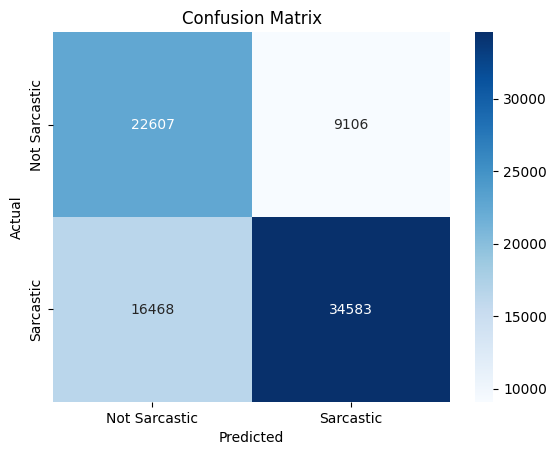

Accuracy: 0.69
Precision: 0.79
Recall: 0.68
F1 Score: 0.73


In [15]:
bert_cross(5, X, y, create_bert1_model, 64, 0.0001, 10, True)

### Add Class Weight

In [30]:
bert1_model = create_bert1_model(0.0001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
bert1_lr4_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2, class_weight = class_weights)


Epoch 1/10
828/828 [==============================] - 22s 13ms/step - loss: 0.6931 - precision_18: 0.6778 - auc_18: 0.5819 - val_loss: 0.6611 - val_precision_18: 0.7734 - val_auc_18: 0.6838
Epoch 2/10
828/828 [==============================] - 10s 12ms/step - loss: 0.6364 - precision_18: 0.7506 - auc_18: 0.6914 - val_loss: 0.6025 - val_precision_18: 0.7468 - val_auc_18: 0.7183
Epoch 3/10
828/828 [==============================] - 9s 11ms/step - loss: 0.6181 - precision_18: 0.7661 - auc_18: 0.7177 - val_loss: 0.6069 - val_precision_18: 0.7788 - val_auc_18: 0.7320
Epoch 4/10
828/828 [==============================] - 10s 12ms/step - loss: 0.6100 - precision_18: 0.7737 - auc_18: 0.7285 - val_loss: 0.6229 - val_precision_18: 0.8083 - val_auc_18: 0.7391
Epoch 5/10
828/828 [==============================] - 8s 10ms/step - loss: 0.6030 - precision_18: 0.7801 - auc_18: 0.7372 - val_loss: 0.5852 - val_precision_18: 0.7657 - val_auc_18: 0.7448
Epoch 6/10
828/828 [==============================] 

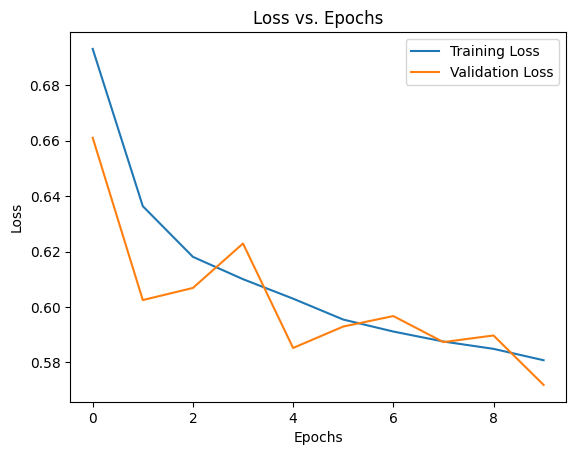

In [31]:
visualise_loss(bert1_lr4_bs64_history)

In [32]:
get_score(get_conf_mat(bert1_model, X_test_padded, y_test), "aef")

518/518 [==============================] - 2s 4ms/step
ok
Accuracy: 0.7
Precision: 0.77
Recall: 0.73
F1 Score: 0.75


(0.7018063190962364,
 0.7696950775314809,
 0.7309022630694733,
 0.7497972424979725)

In [20]:
bert1_model = create_bert1_model(0.00001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
bert1_lr4_bs64_cw_history = bert1_model.fit(X_train_padded, y_train, epochs=100, batch_size=64, validation_split=0.2, class_weight = class_weights)


Epoch 1/100
828/828 [==============================] - 3s 3ms/step - loss: 0.7072 - precision_11: 0.6394 - auc_11: 0.5302 - val_loss: 0.6895 - val_precision_11: 0.6713 - val_auc_11: 0.5635
Epoch 2/100
828/828 [==============================] - 3s 3ms/step - loss: 0.6997 - precision_11: 0.6492 - auc_11: 0.5458 - val_loss: 0.6815 - val_precision_11: 0.6774 - val_auc_11: 0.5824
Epoch 3/100
828/828 [==============================] - 3s 4ms/step - loss: 0.6935 - precision_11: 0.6592 - auc_11: 0.5609 - val_loss: 0.6760 - val_precision_11: 0.6888 - val_auc_11: 0.5977
Epoch 4/100
828/828 [==============================] - 3s 4ms/step - loss: 0.6875 - precision_11: 0.6721 - auc_11: 0.5788 - val_loss: 0.6731 - val_precision_11: 0.7017 - val_auc_11: 0.6124
Epoch 5/100
828/828 [==============================] - 4s 4ms/step - loss: 0.6804 - precision_11: 0.6823 - auc_11: 0.5982 - val_loss: 0.6697 - val_precision_11: 0.7177 - val_auc_11: 0.6278
Epoch 6/100
828/828 [==============================] - 

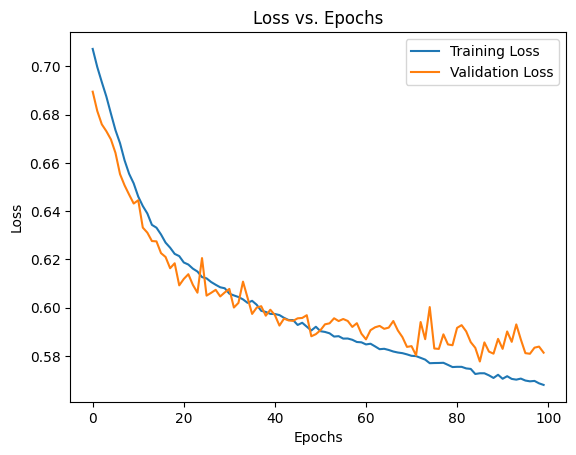

In [21]:
visualise_loss(bert1_lr4_bs64_cw_history)

In [23]:
get_score(get_conf_mat(bert1_model, X_test_padded, y_test), "aef")

518/518 [==============================] - 1s 1ms/step
ok
Accuracy: 0.69
Precision: 0.79
Recall: 0.68
F1 Score: 0.73


(0.6923216335407479,
 0.7909911996294581,
 0.6750667061962644,
 0.7284457478005865)

In [24]:
bert1_model = create_bert1_model(0.00001)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
bert1_lr4_bs128_cw_history = bert1_model.fit(X_train_padded, y_train, epochs=100, batch_size=128, validation_split=0.2, class_weight = class_weights)


Epoch 1/100
414/414 [==============================] - 3s 5ms/step - loss: 0.7274 - precision_12: 0.6235 - auc_12: 0.5112 - val_loss: 0.6971 - val_precision_12: 0.6284 - val_auc_12: 0.5179
Epoch 2/100
414/414 [==============================] - 2s 4ms/step - loss: 0.7163 - precision_12: 0.6277 - auc_12: 0.5185 - val_loss: 0.6945 - val_precision_12: 0.6397 - val_auc_12: 0.5317
Epoch 3/100
414/414 [==============================] - 2s 5ms/step - loss: 0.7098 - precision_12: 0.6345 - auc_12: 0.5299 - val_loss: 0.6892 - val_precision_12: 0.6480 - val_auc_12: 0.5482
Epoch 4/100
414/414 [==============================] - 2s 5ms/step - loss: 0.7051 - precision_12: 0.6401 - auc_12: 0.5389 - val_loss: 0.6849 - val_precision_12: 0.6592 - val_auc_12: 0.5630
Epoch 5/100
414/414 [==============================] - 2s 6ms/step - loss: 0.7014 - precision_12: 0.6458 - auc_12: 0.5471 - val_loss: 0.6805 - val_precision_12: 0.6686 - val_auc_12: 0.5765
Epoch 6/100
414/414 [==============================] - 

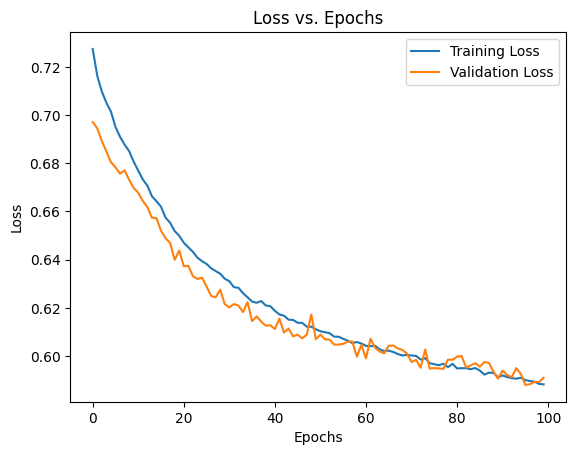

In [27]:
visualise_loss(bert1_lr4_bs128_cw_history)

In [28]:
get_score(get_conf_mat(bert1_model, X_test_padded, y_test), "aef")

518/518 [==============================] - 1s 1ms/step
ok
Accuracy: 0.69
Precision: 0.78
Recall: 0.69
F1 Score: 0.73


(0.691898749471395, 0.7799843802298337, 0.6908785453108015, 0.7327324179855362)

## Final Model and Evaluation

Epoch 1/100
1035/1035 - 6s - loss: 0.7242 - precision_13: 0.6262 - auc_13: 0.5158 - 6s/epoch - 5ms/step
Epoch 2/100
1035/1035 - 4s - loss: 0.7126 - precision_13: 0.6351 - auc_13: 0.5290 - 4s/epoch - 4ms/step
Epoch 3/100
1035/1035 - 4s - loss: 0.7055 - precision_13: 0.6440 - auc_13: 0.5408 - 4s/epoch - 4ms/step
Epoch 4/100
1035/1035 - 4s - loss: 0.7009 - precision_13: 0.6498 - auc_13: 0.5505 - 4s/epoch - 4ms/step
Epoch 5/100
1035/1035 - 3s - loss: 0.6964 - precision_13: 0.6553 - auc_13: 0.5590 - 3s/epoch - 3ms/step
Epoch 6/100
1035/1035 - 3s - loss: 0.6919 - precision_13: 0.6640 - auc_13: 0.5687 - 3s/epoch - 3ms/step
Epoch 7/100
1035/1035 - 3s - loss: 0.6871 - precision_13: 0.6712 - auc_13: 0.5802 - 3s/epoch - 3ms/step
Epoch 8/100
1035/1035 - 3s - loss: 0.6836 - precision_13: 0.6781 - auc_13: 0.5879 - 3s/epoch - 3ms/step
Epoch 9/100
1035/1035 - 3s - loss: 0.6810 - precision_13: 0.6808 - auc_13: 0.5947 - 3s/epoch - 3ms/step
Epoch 10/100
1035/1035 - 3s - loss: 0.6757 - precision_13: 0.693

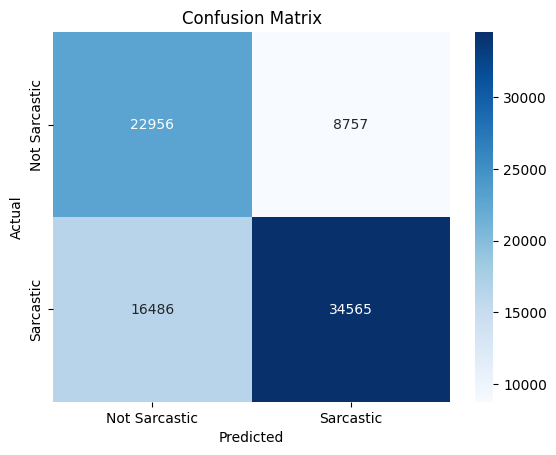

Accuracy: 0.7
Precision: 0.8
Recall: 0.68
F1 Score: 0.73


In [29]:
bert_cross(5, X, y, create_bert1_model, 64, 0.00001, 100, True)